# Neural Networks

By now you should be aware of the "Machine Learning" revolution.  We have chatbots which can answer questions in legible prose.  Computer art generators take a prompt, and draw a fantastical picture which matches it.  There has been a lot of interest in finding ways to apply this technology in Physics.  So far we have not found very many good physics uses for this tool, but it is something which should be in your toolbelt.

One key tool in Machine Learning is the Neural Network.  Functionally, a Neural Network is a highly parameterized function.  It has $N$ inputs, $M$ outputs, and a large number of parameters.  We have tools which allow us to tune these parameters so that the Neural Network can mimic any other function with $N$ inputs and $M$ outputs.  

As a concrete example, think of the text generating component of a chatbot.  Typically it will takes as input the previous few words in the text, and gives the next word as output.  The parameters are chosen so that it tries to match examples of text that it was trained with.

Here is a illustrative figure from [a blog post](https://bansalh944.medium.com/text-generation-using-lstm-b6ced8629b03)
<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*phpgEszN4Q6n_Rtd24zpGw.png">

Another example is image recognition.  Input is the pixels of an image.  Output is a label:  "dog", "cat"...  The parameters are chosen so that it gives the right label for a set of training data.

## Load Packages

In [3]:
using Plots

## Perceptron Layer

In [4]:
struct activation
    f  # f(x)
    df # df/dx as a function of f
end

#examply let f=tanh(x)
# then df/dx=1/cosh^2(x)
# but 1-tanh^2(x)=cosh^2(x)
# so df/dx=1-f^2
a_tanh=activation(tanh,f->1-f^2)

function f_relu(x)
    if x>0
        return x
    else
        return 0
    end
end

function df_relu(f)
    if f>0
        return 1
    else
        return 0
    end
end

a_relu=activation(f_relu,df_relu)

f_logistic(x)=1/(1+exp(-x))
df_logistic(f)=f*(1-f)

a_logistic=activation(f_logistic,df_logistic)

activation(f_logistic, df_logistic)

In [9]:
function showactivation(a::activation,xvals)
    fvals=[a.f(x) for x in xvals]
    dfvals=[a.df(f) for f in fvals]
    plot(xvals,fvals,label="f")
    plot!(xvals,dfvals,label="df/dx")
end

showactivation (generic function with 1 method)

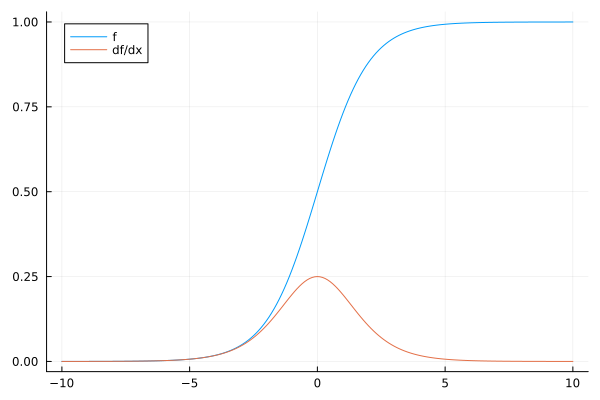

In [13]:
showactivation(a_logistic,-10:0.1:10)

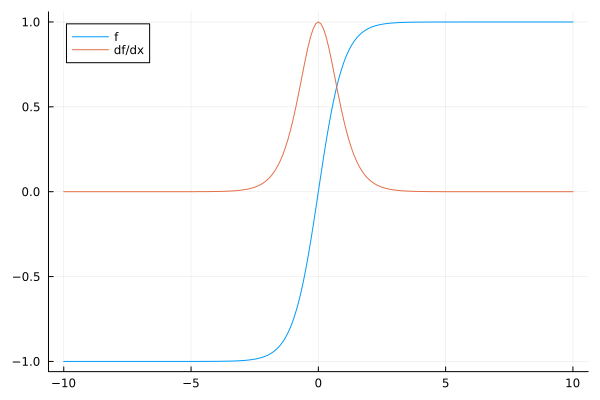

In [14]:
showactivation(a_tanh,-10:0.1:10)

In [15]:
mutable struct layer
    w # Weights matrix
    b # offset matrix
    a :: activation # activation 
    batchsize # set when you run a batch through, to let us know if we need to re-allocate output
    output 
    dindz # result of back-propegation -- derivative of input with respect to final output
    dwdz # result of back-propegation -- derivative of w with respect to final output
    dbdz # result of back=propegation -- derivative of b with respect to final output
end

#constructors
layer(w,b,a)=layer(w,b,a,0,[],[],[],[])
layer(;w,b,a)=layer(w,b,a)

#Run a single instance through layer
function (l::layer)(input)
    l.batchsize=0
    l.output=l.a.f.(l.w*input+l.b)
    return l.output
end

#Run a batch through layer
function (l::layer)(input,batchsize)
    if l.batchsize==batchsize     # We have already allocated the tensors
        return batchevaluate_inplace!(l,input)
    else                          # We have not yet allocated the tensors
        l.batchsize=batchsize
        return batchevaluate!(l,input)
    end
end